## Overview
This notebook serves as a demonstration of the method proposed in the paper and provides the necessary code to reproduce the experiment.


## Setup

In [1]:
# For beam search, we may need to set the environment variable to allow for expandable segments
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [8]:
import sys
#sys.path.append("/home/f/fraser-talientec/")
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
import copy
from contextlib import nullcontext
from tqdm import tqdm, trange


from envsAndScramble import *
from NN_models import *
from cube_training import *
from heuristic_searches import *


import gc

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cpu
os.cpu_count(): 10
zsh:1: command not found: nvidia-smi


In [38]:
#Memory management helpers
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()
    print("GPU memory cleared.")

# Set CUDA memory settings
# torch.cuda.set_per_process_memory_fraction(0.95)  # Use 90% of available GPU memory
# clear_gpu_memory()
#torch.backends.cudnn.benchmark = True



In [10]:
#n_symmetric =13

#env = PermutationGroup(n_symmetric)
env = Cube3()



env_name = env.__class__.__name__
class TrainConfig:
    #max_depth = 26                          # God's Number
    max_depth= 30#8*n_symmetric
    batch_size_per_depth = 200#was 200 for FFN#14#7#0#0#was 100 for big run
    num_steps = 1000000#added 0
    learning_rate = 3e-4
    INTERVAL_PLOT, INTERVAL_SAVE, INTERVAL_BACKUP = 100, 50000, 5000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster
    #SAVE_DIRECTORY = "~/Downloads/cube2d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    SAVE_DIRECTORY = "~"##"/home/f/fraser-talientec/cube3d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    #SAVE_DIRECTORY = "/mnt/extraspace/kitft/cube/"+env_name+"/"
    INTERVAL_VALIDATE = 100
    weight_decay = 1e-3
    max_grad_norm = 1
    name = env_name+"_max_depth_"+str(max_depth)
    dropout = 0.0
    time_embedding_dim = 64# was 64 for big run
    gradient_accumulation_steps = 1
    env = env

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

# Ensure the save directory exists
if not os.path.exists(TrainConfig.SAVE_DIRECTORY):
    os.makedirs(TrainConfig.SAVE_DIRECTORY)




## Environment
Rubik's Cube is operated based on the locations and colors of 6$\times$9 stickers.

We employ [Quarter-Turn Metric](https://www.speedsolving.com/wiki/index.php/Metric#QTM) (90° turns count as one move; 180°, two) for both scrambling and solving the puzzle.


## Model

In [11]:
from NN_models import Model_Cube

# Count and print the number of parameters in the model
model = Model_Cube(width=1000, num_classes=env.num_classes, output_dim=env.num_moves, input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim, dropout_rate=TrainConfig.dropout,n_residual_blocks=4)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

model.to(device)

Total number of parameters in the model: 16,197,012


Model_Cube(
  (embedding): LinearBlock(
    (fc): Linear(in_features=324, out_features=5000, bias=True)
    (gelu): GELU(approximate='none')
    (ln): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=1000, out_features=1000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    )
    (2-5): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=1000, out_features=1000, bias=True)
          (gelu): GELU(approximate='none')
          (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        )
      )
      (time_proj): Linear(in_features=64, out_features=2000, bias=True)

In [6]:

# Initialize model
#print("input_dimension:", env.input_dim)
#print("state dimension:", env.state_dim)
#print("number of classes:", env.num_classes)
# model = TransformerModel_(
#     #input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=TrainConfig.time_embedding_dim,
#     d_model=128,#256,#256,#d_model/num_heads
#     nhead=16,
#     num_layers=3,
#     max_seq_len=env.state_dim,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout,
#     dim_feedforward_transformer=512,
#     dim_MLP_end=1024,
# )
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters in the model: {total_params:,}")

# model.to(device)
# model(torch.tensor(env.state,device=device).unsqueeze(0).repeat(10,1),torch.tensor(0.0,device=device).unsqueeze(0).repeat(10))


## Training

In [ ]:
# 


seed = np.random.randint(0,2**32-1)
print("Using seed:",seed)
# Create the DataLoader
dataloader = DataLoader(
    ScrambleGenerator(max_depth=TrainConfig.max_depth,
                      total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                      env=env,
                      seed=seed),
    num_workers=0,#min(16,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
    batch_size=TrainConfig.batch_size_per_depth
)

iterator=(iter(dataloader))

dataloader_val = DataLoader(
    ScrambleGenerator(max_depth=TrainConfig.max_depth,
                      total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                      env=env,
                      seed=seed+2),  # Added a seed for reproducibility
    num_workers=0,#in(16,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
    batch_size=TrainConfig.batch_size_per_depth,
)

iterator_val=(iter(dataloader_val))
hi_val=next(iterator_val)


In [11]:
# TrainConfig.learning_rate = 3e-4
# TrainConfig.max_grad_norm = 1
# TrainConfig.weight_decay = 1e-10
# TrainConfig.dropout = 0.0
# TrainConfig.gradient_accumulation_steps=50
# #torch.autograd.set_detect_anomaly(True)
# model.to(device)


# #model = deepcopy(model_load).to(device)
model,train_losses_dict = train(model, dataloader, dataloader_val,max_plot_val=30,warmup_frac=0.001)

## Download fonts if necessary

In [13]:
# !ls ~/.fonts/Serif
# # Download and install CMU Serif fonts
# #!wget https://fontlibrary.org/assets/downloads/cmu-serif/59c4efc3fa08079ca44060ca808c8f58/cmu-serif.zip
# #!unzip cmu-serif.zip -d ~/.fonts/
# # Check if CMU Serif font is installed
# !fc-list | grep -i "cmu serif"
# # Check if CMU Serif is in available fonts
# import matplotlib.font_manager as fm

# # Add CMU Serif font files
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunrm.ttf'))  # Regular
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunbx.ttf'))  # Bold
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunti.ttf'))  # Italic
# fm.fontManager.addfont(os.path.expanduser('~/.fonts/Serif/cmunbi.ttf'))  # Bold Italic

# # Rebuild the font cache
# # fm._rebuild()

# # Check if CMU Serif is now available
# fonts = [f.name for f in fm.fontManager.ttflist]
# print("CMU Serif available:", any("CMU Serif" in font for font in fonts))

# # Print all fonts containing "CMU"
# cmu_fonts = [f for f in fonts if "CMU" in f]
# print("\nAll CMU fonts found:")
# for f in cmu_fonts:

#     print(f)


In [11]:
# calculate_validation_loss(dataloader_val, model, num_batches=2)

Validation loss: 0.3768 (calculated over 400 trajectories)


0.3768364191055298

# Prepare for beam search

In [12]:
from envsAndScramble import Cube3
from sympy import primerange


# Get all states 5 moves away
if env.__class__.__name__ == 'Cube3' or env.__class__.__name__ == 'Cube2':
    steps_away = 5
    states_close_to_finish = get_states_n_moves_away_CUBE(env,steps_away)
    states_close_to_finish = np.unique(states_close_to_finish, axis=0)
elif env.__class__.__name__ in ['PermutationGroup','envsAndScramble.PermutationGroup']:
    steps_away = 3
    states_close_to_finish = get_states_n_moves_away_GROUP(env,steps_away)
    states_close_to_finish = np.unique(states_close_to_finish, axis=0)
else:
    raise TypeError(f"env must be an instance of Cube3 or PermutationGroup, actually is: {type(env).__name__}")

# Debug print to check the type of env
print(f"Type of env: {type(env)}")
print(f"Is instance of PermutationGroup: {isinstance(env, envsAndScramble.PermutationGroup)}")
print(f"Is instance of Cube3: {isinstance(env, envsAndScramble.Cube3)}")
print(f"env: {env}")

print(f"Number of unique states {steps_away} moves away: {len(set(map(tuple, states_close_to_finish)))}")
print(f"Total number of states (including duplicates): {len(states_close_to_finish)}")

# Convert states_4_moves to a set of hashed states for efficient lookup
hashed_states_close_to_finish = set(hash_state(state) for state in states_close_to_finish)
hashed_states_close_to_finish_torch = torch.vmap(hash_vectors_torch)(torch.tensor(states_close_to_finish)).to(device)
states_close_to_finish_torch = torch.tensor(states_close_to_finish).to(device)

if env.__class__.__name__ == 'Cube3':   
    # Example usage:
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L','B','R'])  # Apply a short scramble
    print(env.state)
    print("Cube3: Is the scrambled state in our list?", is_state_in_short_distance(env.state,states_close_to_finish))

    # Try with a random state (likely not in our list)
    random_state = np.random.randint(0, 6, size=54)
    print("Is a random state in our list?", is_state_in_short_distance(random_state,states_close_to_finish))
# Example usage with torch tensors:
if env.__class__.__name__ == 'Cube3':
    print("\ntorch")
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L','B','R'])  # Apply a short scramble
    state_tensor = torch.tensor(env.state, device=device)
    print("Cube3: Is the scrambled state in our list (torch)?", is_state_in_short_distance_torch(state_tensor,hashed_states_close_to_finish_torch))
    print("Cube3: Is the scrambled state in our list (actual)?", is_state_actually_in_list_torch(state_tensor,states_close_to_finish_torch))

    # Try with a random state (likely not in our list)
    random_state_tensor = torch.randint(0, 6, (54,), device=device)
    print("Is a random state in our list (torch)?", is_state_in_short_distance_torch(random_state_tensor,hashed_states_close_to_finish_torch))
    print("Is a random state in our list (actual)?", is_state_actually_in_list_torch(random_state_tensor,states_close_to_finish_torch))
    # Try with a batch of states
    batch_size = 3
    batch_states = torch.stack([state_tensor, random_state_tensor, state_tensor])
    print("Results for batch of states (torch):", is_state_in_short_distance_torch(batch_states,hashed_states_close_to_finish_torch))

if env.__class__.__name__ == 'Cube2':
    env.reset()  # Start with a solved cube
    env.apply_scramble(['B',"U'",'L'])  # Apply a short scramble
    print(env.state)
    print("Cube2: Is the scrambled state in our list?", is_state_in_short_distance(env.state,states_close_to_finish))

elif env.__class__.__name__ == 'PermutationGroup':
    # Apply a sequence of moves using the PermutationGroup methods
    state = env.identity.copy()
    moves = [0, 1, 2]  # Indices of moves to apply
    for move_index in moves:
        state = env.apply_move_fast(state, move_index)
    
    print("Scrambled state:", state)
    print("PermutationGroup: Is the scrambled state in our list?", is_state_in_short_distance(state,states_close_to_finish))

    # Generate a random state``
    random_state, _ = env.scramble_fast(5)  # Apply 5 random moves
    print("random_state:", random_state)
    print("PermutationGroup: Is a random state in our list?", is_state_in_short_distance(random_state,states_close_to_finish))

# Compare lengths to check for hash collisions
check_for_hash_collisions(states_close_to_finish,hashed_states_close_to_finish)


Type of env: <class 'envsAndScramble.Cube3'>
Is instance of PermutationGroup: False
Is instance of Cube3: False
env: <envsAndScramble.Cube3 object at 0x7fc8baddba00>
Number of unique states 5 moves away: 94920
Total number of states (including duplicates): 94920
[1 4 5 0 0 1 5 5 2 0 5 0 2 1 1 4 4 1 4 0 0 2 2 0 4 4 4 5 3 3 2 3 3 2 5 5 1
 0 0 1 4 4 2 3 3 3 3 3 5 5 2 2 1 1]
Cube3: Is the scrambled state in our list? False
Is a random state in our list? False

torch
Cube3: Is the scrambled state in our list (torch)? tensor([True], device='cuda:0')
Cube3: Is the scrambled state in our list (actual)? tensor(True, device='cuda:0')
Is a random state in our list (torch)? tensor([False], device='cuda:0')
Is a random state in our list (actual)? tensor(False, device='cuda:0')
Results for batch of states (torch): tensor([ True, False,  True], device='cuda:0')
len(states): 94920, len(set(hashed_states)): 94920
No hash collisions detected


False

# plot some probabilities over time

Testing model2 predictions on sample states:
Loss:  tensor(-0.0109, device='cuda:0')
tensor([[9.9382e-01, 5.6306e-04, 5.6283e-04, 5.6390e-04, 5.6075e-04, 5.6075e-04,
         5.6126e-04, 5.6105e-04, 5.6094e-04, 5.6100e-04, 5.6106e-04, 5.6160e-04],
        [4.9583e-01, 6.1368e-04, 4.9804e-01, 6.1698e-04, 6.1282e-04, 6.1201e-04,
         6.1239e-04, 6.1259e-04, 6.1218e-04, 6.1186e-04, 6.1234e-04, 6.1269e-04],
        [3.2989e-01, 6.6400e-04, 3.2563e-01, 3.3856e-01, 6.5694e-04, 6.5563e-04,
         6.5880e-04, 6.5643e-04, 6.5879e-04, 6.5537e-04, 6.5545e-04, 6.5869e-04],
        [2.4925e-01, 2.4444e-01, 2.4655e-01, 2.5442e-01, 6.6732e-04, 6.6542e-04,
         6.6731e-04, 6.6425e-04, 6.7715e-04, 6.6295e-04, 6.6443e-04, 6.6573e-04],
        [6.7987e-04, 6.7863e-04, 6.8237e-04, 6.7722e-04, 9.9252e-01, 6.8561e-04,
         6.8302e-04, 6.8134e-04, 6.7818e-04, 6.7597e-04, 6.7873e-04, 6.8010e-04],
        [6.1185e-04, 6.0965e-04, 9.9329e-01, 6.1085e-04, 6.1192e-04, 6.1015e-04,
         6.0967e-04

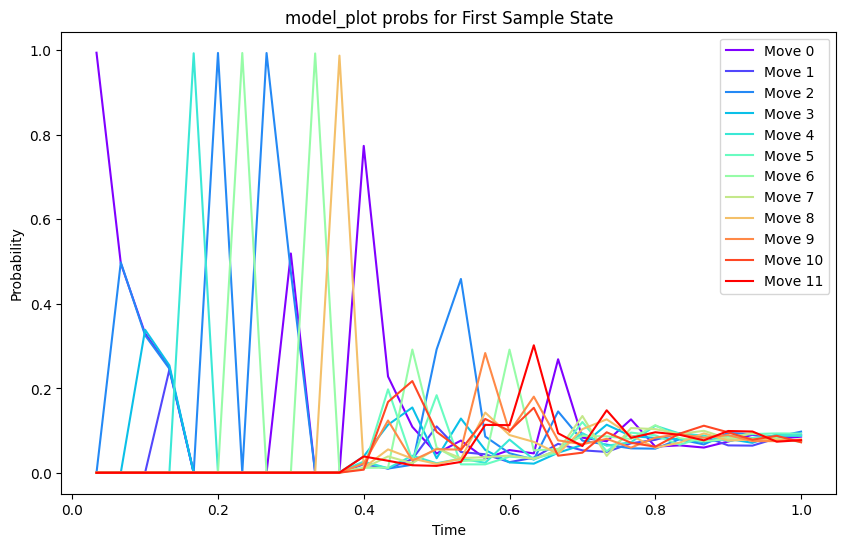

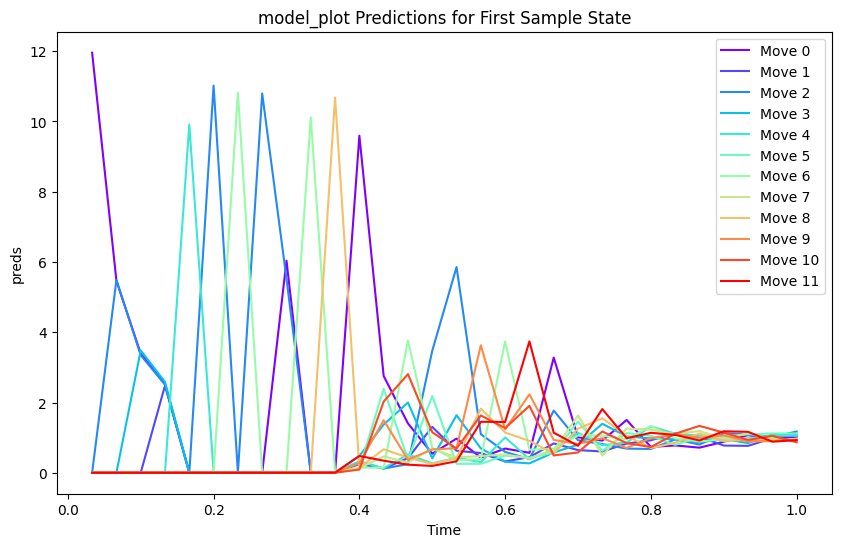

In [13]:
# model2
# Test model2 predictions on some states
model_plot=model.to(device)
xtest = next(iter(dataloader_val))[0]
print("Testing model2 predictions on sample states:")
#sample_states=saved[12:13].to(device)
sample_states=xtest[0:10].to(device)
with torch.no_grad():
    model_plot.eval()
    batch_t = torch.linspace(0 +1/sample_states.shape[1],1, steps=sample_states.shape[1]).to(device).unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)#.unsqueeze(0).repeat(batch_x.shape[0], 1).to(device)
    loss = custom_loss_discrete(model_plot, sample_states, batch_t)
print("Loss: ",loss)

sample_states.shape

# Create a sample batch of cube states
#sample_states = torch.randint(0, 6, (5, 54)).to(device)  # 5 random cube states
# sample_states=hi.to(device)

sample_states_test=sample_states[0].to(device)
#sample_states_test=torch.tensor(test_scrambles[0]).to(device)


# Create time steps
t = torch.linspace(1/TrainConfig.max_depth,1,steps=TrainConfig.max_depth).to(device)#.unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)

# Get model2 predictions
with torch.no_grad():
    model_plot.train()
    predictions = model_plot(sample_states_test, t)#.cpu().detach().numpy()
probabilities = predictions/predictions.sum(axis=-1, keepdims=True)
#print(predictions)
print(probabilities)
#`print("worst is: ", probabilities[5,1])
print(f"Max probability: {probabilities.max().item():.4f}")
print(f"Min probability: {probabilities.min().item():.4f}")
# Print shape of predictions
print(f"Shape of predictions: {probabilities.shape}")

# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, probabilities[:, i].cpu().numpy(), label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot probs for First Sample State")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.show()


# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, predictions[:, i].cpu().numpy(), label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot Predictions for First Sample State")
plt.xlabel("Time")
plt.ylabel("preds")
plt.legend()
plt.show()

# Print the most likely move at the beginning and end of the time sequence for each state
# print("\nMost likely moves:")
# for i in range(5):
#     start_move = torch.argmax(predictions[i, 0, :]).item()
#     end_move = torch.argmax(predictions[i, -1, :]).item()
#     print(f"State {i+1}: Start: Move {start_move}, End: Move {end_move}")


# Download DeepCubeA if necessary

In [14]:
!cd {TrainConfig.SAVE_DIRECTORY}
if True:#"DeepCubeA"!=os.path.join(TrainConfig.SAVE_DIRECTORY, "DeepCubeA").split("/")[-1]:
    if not os.path.exists(os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')):
        !wget -q https://github.com/forestagostinelli/DeepCubeA/archive/refs/heads/master.zip && unzip -q master.zip && mv DeepCubeA-master {os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')} && rm master.zip
    %cd {os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA')}
# !cd ~/cube3d
# from environments import *
# %cd cube3d/DeepCubeA



class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        try:
            # First try to get the class normally
            return super().find_class(module, name)
        except (ModuleNotFoundError, AttributeError):
            # If module/class not found, return a dummy class
            return type(name, (), {})



print('### Optimal Solver ###')
filename = os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA/data/cube3/test/data_0.pkl')
with open(filename, 'rb') as f:
    result_Optimal = CustomUnpickler(f).load()  # Force load pickle data even with missing modules

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i)
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = os.path.join(TrainConfig.SAVE_DIRECTORY, 'DeepCubeA/results/cube3/results.pkl')
with open(filename, 'rb') as f:
    result_DeepCubeA = CustomUnpickler(f).load()

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")


/home/f/fraser-talientec/cube3d/DeepCubeA
### Optimal Solver ###
dict_keys(['states', 'times', 'solutions', 'num_nodes_generated'])
No. of cases: 1000

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 1000
/home/f/fraser-talientec/cube3d
Example:
[['D', -1], ['F', 1], ['R', 1], ['U', -1], ['F', 1], ['F', 1], ['R', 1], ['U', 1], ['F', 1], ['R', 1], ['B', -1], ['R', -1], ['F', -1], ['R', -1], ['D', -1], ['U', -1], ['R', -1], ['U', -1], ['U', -1], ['R', -1], ['U', 1], ['B', -1]]
-> ['B', "U'", 'R', 'U', 'U', 'R', 'U', 'D', 'R', 'F', 'R', 'B', "R'", "F'", "U'", "R'", "F'", "F'", 'U', "R'", "F'", 'D']


## Inference

We test and compare on the DeepCubeA dataset

### Beam Search

A highly optimized beam search implementation that pre-allocates tensors and avoids redundant GPU transfers. Uses batched operations and efficient tensor operations to evaluate hundreds of thousands of cube states in parallel. Includes deduplication of states and can handle multiple starting states. The core algorithm maintains a fixed-size beam of the most promising states and expands them using model predictions at each depth.

In [15]:
model_to_use = model
result_ours = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
start_step_for_beam = 0
dict_to_fill = result_ours
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

pbar = tqdm(test_scrambles[0:], position=0)
last_result = "No solves yet"
pbar.set_description(f"Last: {last_result}")

for i, scramble in enumerate(pbar):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
    

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=start_step_for_beam,
                                                        close_states=states_close_to_finish_torch,hashed_states=hashed_states_close_to_finish_torch,max_forward_pass=2**18)
    solve_time = time.time() - solve_start
    clear_output(wait=True)
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves
        
        for k in dict_to_fill.keys():
            dict_to_fill[k].append(result[k])
        sol_lengths = [len(e)+5 for e in dict_to_fill['solution'] if e is not None]
        last_result = f"Success - Length {solve_length} vs Optimal {optimal_length}, avg = {np.mean(sol_lengths):.2f}, Failures = {sum(x is None for x in dict_to_fill['solution'])}"
    else:
        last_result = f"Failed to solve, avg = {np.mean(sol_lengths):.2f}, Failures = {sum(x is None for x in dict_to_fill['solution'])}"
        for k in dict_to_fill.keys():
            dict_to_fill[k].append(None)
            
    # Clear previous description and update
    pbar.set_description(f"Last: {last_result}")

Last: Success - Length 21 vs Optimal 21, avg = 21.37, Failures = 0: 100%|█| 1000


In [16]:
model_to_use = model
result_ours_start_step_2 = {
    "solution":[],
    "num_nodes_generated":[],
    "time":[]
}
start_step_for_beam = 2
dict_to_fill = result_ours_start_step_2
# Set CUDA allocation config
#torch.cuda.set_per_process_memory_fraction(0.95)  # Leave some headroom
#if os.environ['PYTORCH_CUDA_ALLOC_CONF'] != 'expandable_segments:True':
#    raise ValueError("PYTORCH_CUDA_ALLOC_CONF must be set to 'expandable_segments:True'")

pbar = tqdm(test_scrambles[0:], position=0)
last_result = "No solves yet"
pbar.set_description(f"Last: {last_result}")

for i, scramble in enumerate(pbar):
    if i%10==0:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        import gc
        gc.collect()
    

    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    solve_start = time.time()
    success, result, path,attempt = beam_search_fast_AC(env, model_to_use,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=2**18,attempts=1,expensive_pick_best=True,start_step=start_step_for_beam,
                                                        close_states=states_close_to_finish_torch,hashed_states=hashed_states_close_to_finish_torch,max_forward_pass=2**18)
    solve_time = time.time() - solve_start
    clear_output(wait=True)
    if success:
        solve_length = len(path) + 5  # Add 5 for short distance moves
        
        for k in dict_to_fill.keys():
            dict_to_fill[k].append(result[k])
        sol_lengths = [len(e)+5 for e in dict_to_fill['solution'] if e is not None]
        last_result = f"Success - Length {solve_length} vs Optimal {optimal_length}, avg = {np.mean(sol_lengths):.2f}, Failures = {sum(x is None for x in dict_to_fill['solution'])}"
    else:
        last_result = f"Failed to solve, avg = {np.mean(sol_lengths):.2f}, Failures = {sum(x is None for x in dict_to_fill['solution'])}"
        for k in dict_to_fill.keys():
            dict_to_fill[k].append(None)
            
    # Clear previous description and update
    pbar.set_description(f"Last: {last_result}")

Last: Success - Length 21 vs Optimal 21, avg = 21.33, Failures = 0: 100%|█| 1000


In [59]:
# Print average solution lengths for each result dictionary
for result_dict_name in ['result_ours', 'result_ours_start_step_1', 'result_ours_start_step_2', 'result_ours_start_step_3', 'result_ours_start_step_4']:
    if result_dict_name in locals():
        result_dict = locals()[result_dict_name]
        result_dict['solution_lengths'] = [len(e)+5 for e in result_dict['solution'] if e is not None]
        print(f"Average length ({result_dict_name}): {np.mean(result_dict['solution_lengths']):.2f}")



Average length (result_ours): 21.39
Average length (result_ours_start_step_1): 21.37
Average length (result_ours_start_step_2): 21.34
Average length (result_ours_start_step_3): 21.36
Average length (result_ours_start_step_4): 21.64


In [28]:
# Save all result dictionaries to a single npz file
results_dict = {}
for result_dict_name in ['result_ours', 'result_ours_start_step_1', 'result_ours_start_step_2', 'result_ours_start_step_3', 'result_ours_start_step_4']:
    if result_dict_name in locals():
        result_dict = locals()[result_dict_name]
        # Convert to numpy arrays for saving
        results_dict[result_dict_name] = result_dict

np.savez('beam_search_results_2.npz', **{'results': results_dict})
print("Saved all results to beam_search_results.npz")



Saved all results to beam_search_results.npz


Average length: 21.32
Successfully solved 1000 cases out of 1000
Average extra steps compared to optimal: 0.69
Average length: 21.32


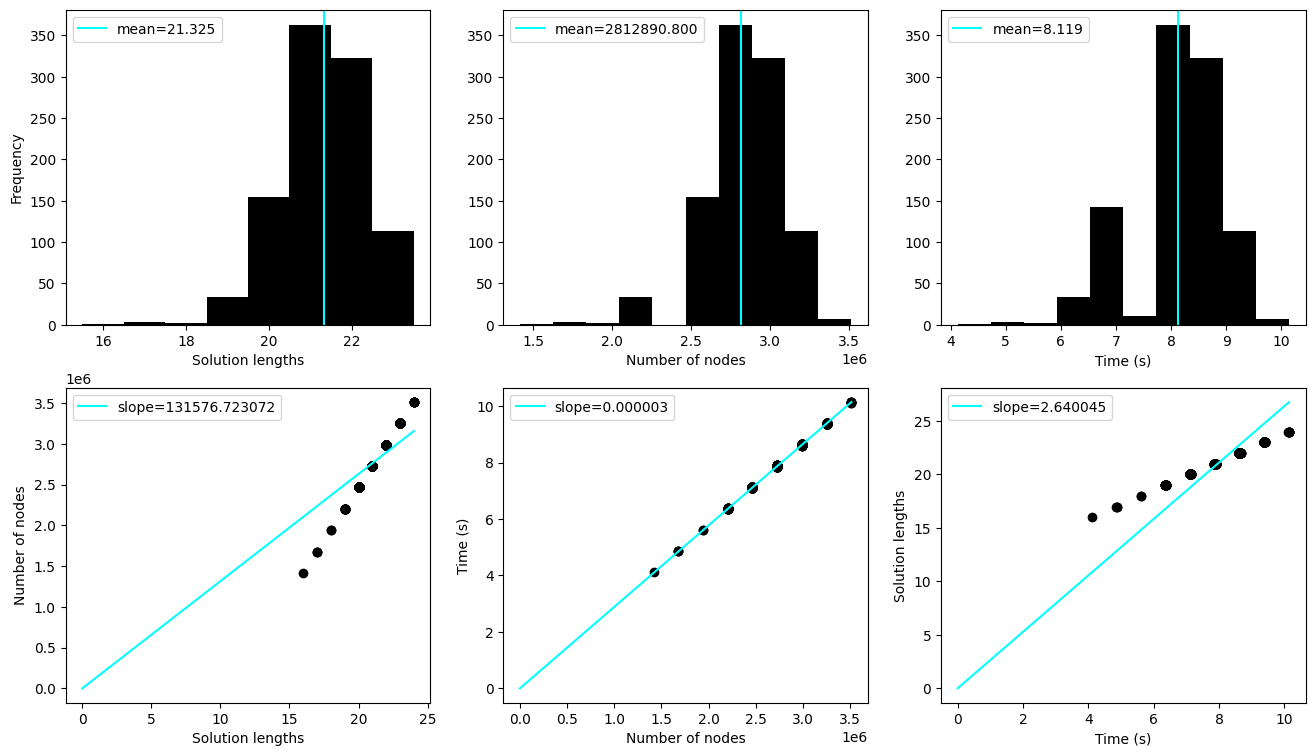

In [29]:
result_ours_plot = result_ours_start_step_2
result_ours_plot['solution_lengths'] = [len(e)+5 for e in result_ours_plot['solution'] if e is not None]
print(f"Average length: {np.mean(result_ours_plot['solution_lengths']):.2f}")
result_ours_plot['solution_lengths_count'] = {
    i: result_ours_plot["solution_lengths"].count(i)
    for i in range(min(result_ours_plot["solution_lengths"]), max(result_ours_plot["solution_lengths"]))
}
result_ours_plot['times'] = [t for t in result_ours_plot['time'] if t is not None]
print(f"Successfully solved {len(result_ours_plot['time'])} cases out of {len(result_ours_plot['solution'])}")
 
average_extra_steps = np.mean([length - optimal for length, optimal in zip(result_ours_plot['solution_lengths'], result_Optimal['solution_lengths'])])
print(f"Average extra steps compared to optimal: {average_extra_steps:.2f}")
print(f"Average length: {np.mean(result_ours_plot['solution_lengths']):.2f}")

# Visualize result0
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours_plot[k]
    if k=="solution_lengths":
        v_count = result_ours_plot['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours_plot[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef, label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

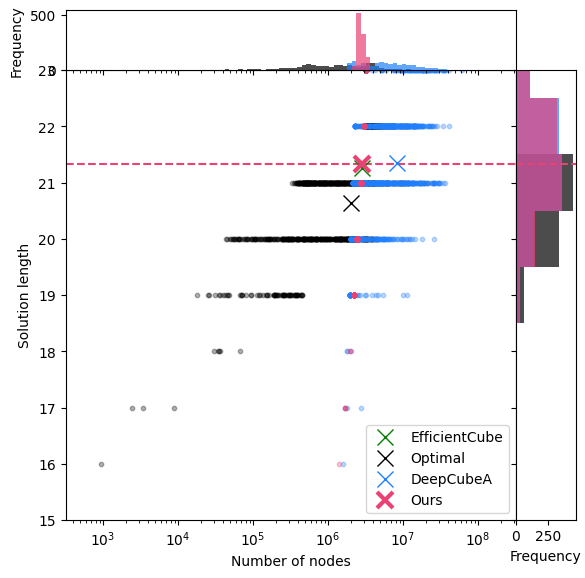

In [36]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]
# plt.rcParams.update(plt.rcParamsDefault)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_ylim(15, max(result_ours_plot['solution_lengths_count']))
ax_histy.set_ylim(15, max(result_ours_plot['solution_lengths_count']))

xmin, xmax = 2.5, 8.5
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################

key_x, key_y = "num_nodes_generated", "solution_lengths"

for k, data in [("Optimal", result_Optimal), ("DeepCubeA", result_DeepCubeA), ("Ours", result_ours_plot)]:
    x, y = data[key_x], data[key_y]
    ax.scatter(x, y, s=10, alpha=0.3)
    ax_histx.hist(x, bins=bins_x, alpha=0.7)

for i, data in enumerate([result_Optimal, result_DeepCubeA, result_ours_plot]):
    data = data["solution_lengths_count"]
    ax_histy.barh(list(data.keys()), list(data.values()), height=1, alpha=0.7)

ax_histy.axhline(np.mean(result_ours_plot[key_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours_plot[key_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_ours_plot[key_x]), 21.26,           "x", markersize=12, label="EfficientCube", color='green')
ax.plot(np.mean(result_Optimal[key_x]), np.mean(result_Optimal[key_y]),     "x", markersize=12, label="Optimal")
ax.plot(np.mean(result_DeepCubeA[key_x]), np.mean(result_DeepCubeA[key_y]), "x", markersize=12, label="DeepCubeA")
ax.plot(np.mean(result_ours_plot[key_x]), np.mean(result_ours_plot[key_y]),           "x", markersize=12, label="Ours", markeredgewidth=3)
ax.legend()

plt.show()

In [37]:
model.device

AttributeError: 'Model_Cube' object has no attribute 'device'